# Introduction to inference: hands on

#### Greg Ashton

* [GW Parameter Estimation workshop 2020](https://github.com/GregoryAshton/GWParameterEstimationWorkshop2020)
* [Notebook available here](https://github.com/GregoryAshton/GWParameterEstimationWorkshop2020/blob/master/notebooks/introduction_to_inference.ipynb)




To serve this content: `jupyter nbconvert introduction_to_inference.ipynb --to slides --post serve`

In [46]:
! pip install -q 'bilby'

In [47]:
# Setup for the notebook: imports and set log levels to not produce too much output
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Bilby imports
import bilby
from bilby.core.likelihood import GaussianLikelihood
from bilby.core.prior import Uniform

# This is just to reduce the overall output, remove this when running locally
#bilby.utils.setup_logger(log_level="WARNING")

# This is just to make things "pretty" for presentation
import seaborn
np.random.seed(123)
seaborn.set_context("talk")
seaborn.set_style("whitegrid")

## Installation

You need to install the relevant software, for this tutorial all you will need to do is run

```
$ pip install bilby
```

You can check this works by doing the following:

In [48]:
import bilby
print(bilby.__version__)

1.0.1: release


# Inference/Data analysis workshop: overview

- An aside on conditional probability and Bayes' theorem/one-liner
- Introduction to inference
- Inference from scratch
- Bilby as a black box
- Bilby likelihoods
- Bilby priors
- Bilby model selection

## An aside on conditional probability and Bayes' theorem/one-liner

- Throughout this tutorial, we'll be using the oft-talked about [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$ P(A|B) = \frac{P(B|A)P(A)}{P(B)} $$

- Before we begin, let's make sure we understand it

**Question:** What is the probability of drawing a red-suit card from a pack of 52 cards?

**Answer:** It is 1/2 *if* the 52-card deck of cards is regular

**Question:** How do you express that mathematically?

**Answer:**

$$ P(\textrm{red-card} | I) = \frac{1}{2} $$

where

$$ I \equiv \textrm{"normal 52-card deck"} $$

is our *background* information.

*The vertical line above can be read as "given"*

**Question:** What is the probability of drawing <span style="color:red"> 2 red-suit card from a pack of 52 cards</span>?

**Answer:** Uhh.. hang on let me draw a diagram
```
           O      
        /     \
       /       \
      R0       B0
      / \      /\
     /   \    /  \
    R1   B1  R1  B1
```

So...
$$R_0 = \frac{26}{52}=\frac{1}{2} \;\; \textrm{ and }\;\; R_1=\frac{26-1}{52-1}=\frac{25}{51}$$
so the probability of both occuring is 
$$ R_1 \times R_0 = \frac{25}{102} $$

**Question:** How do you express that mathematically?

**Answer:** We want $P(R_0, R_1| I)$, so we need to use *conditional probability*

$$ P(R_0, R_1| I) = P(R_1 | R_0, I) P(R_0| I) $$

with
$$ P(R_0 | I) = \frac{1}{2} $$
and
$$ P(R_1 | R_0, I) = \frac{\textrm{Number of red cards}}{\textrm{Number of cards}} = \frac{26-1}{52-1} = \frac{25}{51} $$

And so finally
$$ P(R_0, R_1| I) = \frac{1}{2} \times \frac{25}{51} = \frac{25}{102}$$

### Okay sorry, where were we?

You all understand conditional probability 
$$P(A, B| I ) = P(A| B, I)P(B, I)$$

But we can write that the other way around
$$P(A, B| I ) = P(B| A, I)P(A, I)$$

Then with a little algebra

$$ P(A| B, I) = \frac{P(B| A, I) P(A| I)}{P(B| I)} $$

- Which is just... Bayes' theorem.

- Maybe we should just call it Bayes' one-liner?

## Introduction to Inference

- **Inference is about figuring something out from the data**

- We will label, for now, our data as $\textbf{data}$

- Once you have some data it is time to decide what you want to figure out.

- Inference can be thought of in two ways:
  1. **Parameter estimation**: "*I want to figure our what model parameters $\theta$ best-fit my data, given some model $M_A$*"
  2. **Model selection**: "*I want to figure our which model, $M_A$ or $M_B$ best fits my data*"

## Parameter Estimation

Parameter estimation is about figuring out the model parameters $\theta$ given some model $M_A$

$$ P(\theta| M_A, \mathbf{data}) = \frac{P(\mathbf{data}| M_A, \theta) P(\theta | M_A)}{P(\mathbf{data} | M_A)}$$

The denomoninator here only normalises the distribution, so often people will simplify

$$ P(\theta| M_A, \mathbf{data}) \propto P(\mathbf{data}| M_A, \theta) P(\theta | M_A)$$

For consistency with notation elsewhere, this is often written

$$ \underbrace{P(\theta| M_A, \mathbf{data})}_{\textrm{posterior}} \propto \underbrace{\mathcal{L}(\mathbf{data}| M_A, \theta)}_{\textrm{likelihood}} \underbrace{\pi(\theta | M_A)}_{\textrm{prior}}$$

### Example 1: one-dimensional posterior distribution

Let's talk about some specific data $\mathbf{y} = [y_0, y_1, \ldots, y_N]$ observed at times $\mathbf{t} = [t_0, t_1, \ldots, t_N]$.

To be concrete: we will say

- Our model is
$$ M_A: y_A(t; \omega) = \sin(\omega t) $$
- We have one model parameter, i.e. $\mathbf{\theta}=[\omega]$

In [49]:
def modelA(time, omega):
    return np.sin(omega * time)

Okay, let's simulate some data

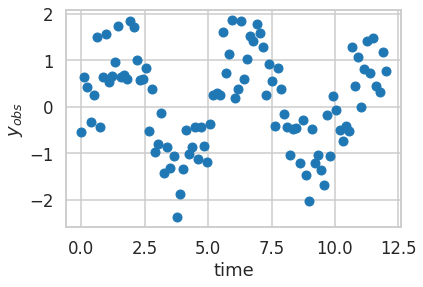

In [50]:
sigma = 0.5
omega_true = 1.2
time = np.linspace(0, 12, 100)
ydet = modelA(time, omega=omega_true)
yobs = ydet + np.random.normal(0, sigma, len(time))  # Observed data = SIGNAL + GAUSSIAN NOISE

plt.plot(time, yobs, "o")
plt.ylabel("$y_{obs}$"); plt.xlabel("time")
plt.show()

In [51]:
2e-2

0.02

We want to *figure something out from the data*. Let's figure out the frequency

The *noise* is Gaussian, i.e. we have

$$ y_\textrm{obs} = y_\textrm{det} + \textrm{noise} => \textrm{noise} = y_\textrm{obs} - y_\textrm{det}$$

So, if we have a single data point $y_i, t_i$, then given a particular $\omega$

$$\mathcal{L}(y_i, t_i | \omega, M_A, \sigma=0.1) = \textrm{Normal}(y - y_A(t; \omega); \sigma=0.1) 
= \frac{1}{\sqrt{2\pi\sigma^2}} \mathrm{exp}\left(-\frac{(y_i-y(t_i)^2)}{2\sigma^2}\right)$$

It is a good idea to work with the log-likelihood
$$ \ln\mathcal{L}(y_i, t_i | \omega, M_A, \sigma=0.1) = -\frac{1}{2}\left(
\frac{(y_i-y_A(t_i))^2}{\sigma^2} + \ln({2\pi\sigma^2})
\right)$$

Last, we want the likelihood from **all** the data:
$$\mathcal{L}(\mathbf{y}, \mathbf{t} | \omega, M_A, \sigma=0.1) = \prod_{i}\mathcal{L}(y_i, t_i | \omega, M_A, \sigma=0.1)$$
or
$$\ln\mathcal{L}(\mathbf{y}, \mathbf{t} | \omega, M_A, \sigma=0.1) = \sum_{i}\ln\mathcal{L}(y_i, t_i | \omega, M_A, \sigma=0.1)$$

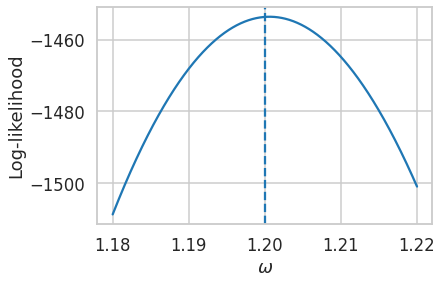

In [52]:
def ln_likelihood(yobs, time, omega, sigma=0.1):
    yA = modelA(time, omega)
    ln_likes = -0.5 * ((yobs - yA)**2 / sigma**2 + np.log(2*np.pi*sigma**2))
    return np.sum(ln_likes)

#uniform prior, 2e-2 = 2*10^-2 
omega_grid = np.linspace(omega_true-2e-2, omega_true+2e-2, 1000)

ln_likelihood_grid = []
for omega in omega_grid:
    ln_likelihood_grid.append(ln_likelihood(yobs, time, omega))
    
plt.plot(omega_grid, ln_likelihood_grid)
plt.axvline(omega_true, ls='--')
plt.xlabel("$\omega$")
plt.ylabel("Log-likelihood")
plt.show()

### Max likelihood

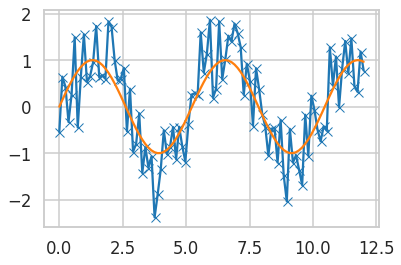

In [53]:
max_likelihood_omega = omega_grid[np.argmax(ln_likelihood_grid)]
plt.plot(time, yobs, '-x')
plt.plot(time, modelA(time, max_likelihood_omega))
plt.show()

## Posteriors

$$ P(\omega | \mathrm{data}) \propto \mathcal{L}(\mathrm{data}| \omega) \times \pi(\omega) $$

- If $\pi(\omega) \propto \textrm{const.}$, then $P(\omega | \mathrm{data}) \propto \mathcal{L}(\mathrm{data}| \omega)$
- If not, then one needs to do multiply by the prior.
- For the time being let's take the easier case

### Normalised posterior density function (pdf)

Let's plot the posterior (equal to the likelihood in this case) taking an exponent

In [54]:
np.mean([1,2,3,4,5,4,3,2,1])

2.7777777777777777

In [55]:
np.mean(ln_likelihood_grid)

-1470.7589763165158

In [56]:
np.max(ln_likelihood_grid), np.min(ln_likelihood_grid)

(-1453.665041894708, -1508.610729605472)

In [57]:
[(np.min(ln_likelihood_grid)-np.mean(ln_likelihood_grid)),(np.max(ln_likelihood_grid)-np.mean(ln_likelihood_grid))]

[-37.85175328895616, 17.093934421807717]

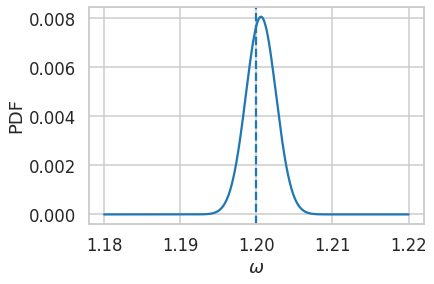

In [58]:
#ln_likelihood_grid contains value of ln likelihood for various omega in an array 
pdf_unnormalized = np.exp(ln_likelihood_grid - np.mean(ln_likelihood_grid))

#gives value of PDF at each omega value
pdf_normalized = pdf_unnormalized / np.sum(pdf_unnormalized)

plt.plot(omega_grid, pdf_normalized)
plt.axvline(omega_true, ls='--')
plt.xlabel("$\omega$")
plt.ylabel("PDF")
plt.show()

### Why is the peak not consistent with the true value?

- Cleary the median of this distribution does **not** agree with the true value
- The *noise* in the observed data means that we have uncertainty!
- How can be quantify this?
- Bayesian answer is the [credible interval](https://en.wikipedia.org/wiki/Credible_interval) 
- We should always report inferences as $\omega$ has a median of XX and lies between YY and ZZ with 95\% probability
- How do we figure out these numbers?

## Cumulative distribution

First, let's calculate the cumulative distribution function

$$ \mathrm{CDF}(\omega) = \int_{-\infty}^{\omega} P(\omega'| \mathrm{data})\, d\omega' $$

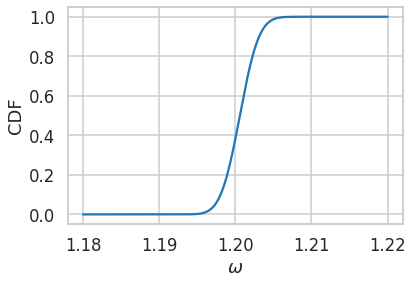

In [59]:
cdf = np.cumsum(pdf_normalized)
plt.plot(omega_grid, cdf)
plt.xlabel("$\omega$")
plt.ylabel("CDF")
plt.show()

- The median is the point where the CDF passes through 0.5
- We can find the 90% confidence interval by finding the 0.05 and 0.95 numbers (such that the interval contains 90% of the probability)

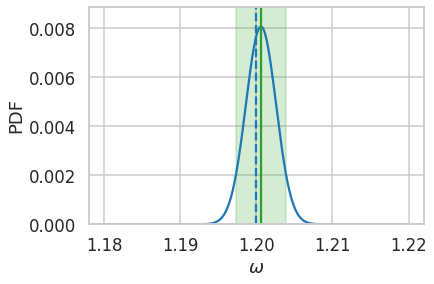

In [60]:
median = omega_grid[np.argmin(np.abs(cdf - 0.5))]
low_bound = omega_grid[np.argmin(np.abs(cdf - 0.05))]
upper_bound = omega_grid[np.argmin(np.abs(cdf - 0.95))]

plt.plot(omega_grid, pdf_normalized)
plt.axvline(omega_true, ls='--')
plt.fill_between([low_bound, upper_bound], 0, 2 * np.max(pdf_normalized), color='C2', alpha=0.2)
plt.axvline(median, color='C2')
plt.ylim(0, 1.1 * np.max(pdf_normalized)); plt.xlabel("$\omega$"); plt.ylabel("PDF")
plt.show()

## What happens when things get more complicated?

- In low-dimensions, evaluating a grid of points isn't too crazy
- In high-dimensionl problems, the number of grid points scales with the number of dimensions!
- Here we turn to stochastic sampling algorithms

## First, let's build a peak-finding algorithm


In [61]:
#last value of omega_values, counting from the right
#omega_values[-1]

len of points for converging =  7


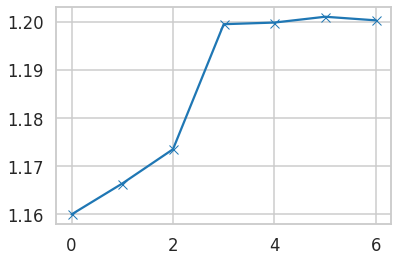

In [62]:
'''def ln_likelihood(yobs, time, omega, sigma=0.1):
    yA = modelA(time, omega)
    ln_likes = -0.5 * ((yobs - yA)**2 / sigma**2 + np.log(2*np.pi*sigma**2))
    return np.sum(ln_likes)'''


#ln_likelihood gives likelihood of a observed data set and given omega
omega_values = [1.16] # Pick a starting point
ln_likelihood_values = [ln_likelihood(yobs, time, omega_values[0])]

for i in range(100):
    proposed_point = omega_values[-1] + np.random.normal(0, 0.01) #this normal distribution is the markov chain one, not the gaussian ditribution of the noise
    ln_likelihood_proposed = ln_likelihood(yobs, time, proposed_point)
    
    if ln_likelihood_proposed > ln_likelihood_values[-1]:
        omega_values.append(proposed_point)
        ln_likelihood_values.append(ln_likelihood_proposed)

#automatically assigned x axis value as [0,1,2,...]  
print('len of points for converging = ', len(omega_values))    
plt.plot(omega_values, '-x')
plt.show()

- Good at finding the peak of a unimodel likelihood to arbitrary precision
- Bad if things are multimodal
- Doesn't tell us anything about the "structure"

### Very basic Metropolis-Hastings sampler

Markov-Chain Monte-Carlo samplers use "randomness" to sample from the posterior distribution

In [63]:
#generates random no. between 0 and 1
np.random.rand()

0.23824990571241178

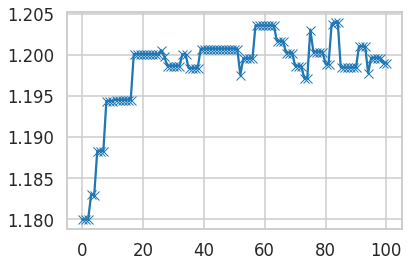

In [64]:
omega_values = [1.18] # Pick a starting point
ln_likelihood_values = [ln_likelihood(yobs, time, omega_values[0])]

for i in range(100):
    proposed_point = omega_values[-1] + np.random.normal(0, 0.01)
    ln_likelihood_proposed = ln_likelihood(yobs, time, proposed_point)
    
    #below line can written,  ln_likelihood_proposed - ln_likelihood_values[-1] > np.log(np.random.rand())
    #taking exp of both side, likelihood_proposed/likelihood_values[-1] > (np.random.rand())
    if ln_likelihood_proposed > ln_likelihood_values[-1] + np.log(np.random.rand()):
        omega_values.append(proposed_point)
        ln_likelihood_values.append(ln_likelihood_proposed)

    #in MCMC 'else' is not there i.e. it appends only when the jump occurs
    else:
        omega_values.append(omega_values[-1])
        ln_likelihood_values.append(ln_likelihood_values[-1])
        
plt.plot(omega_values, '-x')
plt.show()

### Run it with a few more steps...

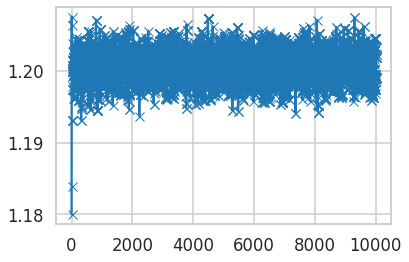

In [65]:
omega_values = [1.18] # Pick a starting point
ln_likelihood_values = [ln_likelihood(yobs, time, omega_values[0])]

for i in range(10000):
    proposed_point = omega_values[-1] + np.random.normal(0, 0.01)
    ln_likelihood_proposed = ln_likelihood(yobs, time, proposed_point)
    
    if ln_likelihood_proposed > ln_likelihood_values[-1] + np.log(np.random.rand()):
        omega_values.append(proposed_point)
        ln_likelihood_values.append(ln_likelihood_proposed)
    else:
        omega_values.append(omega_values[-1])
        ln_likelihood_values.append(ln_likelihood_values[-1])
        
plt.plot(omega_values, '-x')
plt.show()

### Histogram the samples

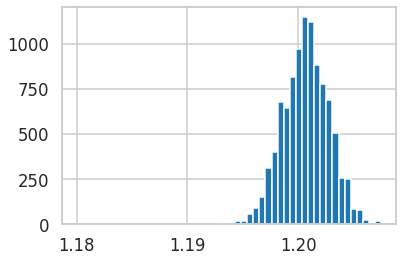

In [66]:
_ = plt.hist(omega_values, bins=50)

In [67]:
#len(omega_values2)

median omega =  1.2007495134128896


(array([  1.,   1.,   6.,   6.,  17.,  28.,  55., 113., 137., 222., 246.,
        290., 344., 380., 366., 273., 271., 211., 142.,  84.,  58.,  31.,
         14.,   1.,   4.]),
 array([1.19310511, 1.19367287, 1.19424062, 1.19480837, 1.19537612,
        1.19594388, 1.19651163, 1.19707938, 1.19764713, 1.19821489,
        1.19878264, 1.19935039, 1.19991814, 1.2004859 , 1.20105365,
        1.2016214 , 1.20218915, 1.2027569 , 1.20332466, 1.20389241,
        1.20446016, 1.20502791, 1.20559567, 1.20616342, 1.20673117,
        1.20729892]),
 <a list of 25 Patch objects>)

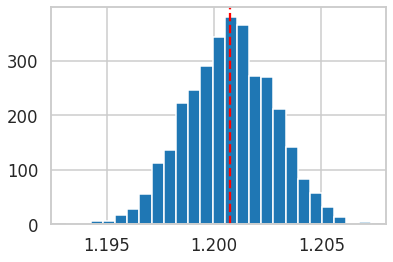

In [68]:
#omega_true = 1.2
omega_values2 = omega_values[100:]
omega_values2 = omega_values2[::3]
print('median omega = ', np.median(omega_values2))
plt.axvline(np.median(omega_values2), ls='--', color='r')
plt.hist(omega_values2, bins=25)


## Sampling takeaways

- Stochastic samplers are all about drawing "samples" from the posterior distribution

- Simple MCMC methods need tuning

- Advanced MCMC methods have fewer tuning parameters
  - Parallel tempering is required to deal with multi-model distributions
  - Can calculate evidences, but not advised
  
- Nested Sampling is better than MCMC
  - Calculated evidences by design
  - Deals well with multimodal distributions

## Using Bilby

- Bilby is a generic Bayesian inference library
- Special support for Gravitational-Wave Transient's (focus of this workshop)
- First, let's introduce it in a simple setting

<img src="https://git.ligo.org/uploads/-/system/project/avatar/1846/bilby.jpg?width=64" alt="drawing" width="200"/>

## Bilby provides a easy-to-use interface for common inference tasks

Let's repeat what we did above, but in bilby

We want to *figure something out from the data*. Let's figure out the frequency

The *noise* is Gaussian, i.e. we have

$$ y_\textrm{obs} = y_\textrm{det} + \textrm{noise} => \textrm{noise} = y_\textrm{obs} - y_\textrm{det}$$

So, if we have a single data point $y_i, t_i$, then given a particular $\omega$

$$\mathcal{L}(y_i, t_i | \omega, M_A, \sigma=0.1) = \textrm{Normal}(y - y_A(t; \omega); \sigma=0.1) 
= \frac{1}{\sqrt{2\pi\sigma^2}} \mathrm{exp}\left(-\frac{(y_i-y(t_i)^2)}{2\sigma^2}\right)$$

It is a good idea to work with the log-likelihood
$$ \ln\mathcal{L}(y_i, t_i | \omega, M_A, \sigma=0.1) = -\frac{1}{2}\left(
\frac{(y_i-y_A(t_i))^2}{\sigma^2} + \ln({2\pi\sigma^2})
\right)$$

Last, we want the likelihood from **all** the data:
$$\mathcal{L}(\mathbf{y}, \mathbf{t} | \omega, M_A, \sigma=0.1) = \prod_{i}\mathcal{L}(y_i, t_i | \omega, M_A, \sigma=0.1)$$
or
$$\ln\mathcal{L}(\mathbf{y}, \mathbf{t} | \omega, M_A, \sigma=0.1) = \sum_{i}\ln\mathcal{L}(y_i, t_i | \omega, M_A, \sigma=0.1)$$

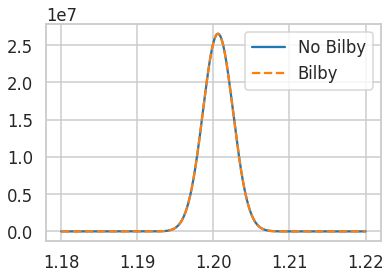

In [69]:
'''def modelA(time, omega):
    return np.sin(omega * time)'''

likelihood = bilby.likelihood.GaussianLikelihood(time, yobs, modelA, sigma=0.1)

ln_likelihood_grid_bilby = []
for omega in omega_grid:
    likelihood.parameters["omega"] = omega
    ln_likelihood_grid_bilby.append(likelihood.log_likelihood())
    
plt.plot(omega_grid, np.exp(ln_likelihood_grid - np.mean(ln_likelihood_grid)), label="No Bilby")
plt.plot(omega_grid, np.exp(ln_likelihood_grid_bilby - np.mean(ln_likelihood_grid_bilby)), '--', label="Bilby")
plt.legend()
plt.show()

In [70]:
len(omega_grid)

1000

## Increasing complexity

- What happens if we increase the complexity?
- What if our model looks like this

$$ y_B(t) = A\sin(\omega t + \phi_0)$$

- And we don't know what $\sigma$ is?

We **could** repeat the operation above:
- Create a grid (now in 4D)
- Evaluate the likelihood over the grid and find a maximum

**But**: the number of grid point we need is $\propto (\textrm{the grid spacing})^N$

## Stochastic Sampling methods: as a black box

In [71]:
def modelB(time, omega, A, phi0):
    return A * np.sin(omega * time + phi0)

#sigma is not defined here
likelihood = bilby.likelihood.GaussianLikelihood(time, yobs, modelB)

priors = dict(
    A=Uniform(0, 2, "A"),
    omega=Uniform(1, 1.5, "omega"),
    phi0=Uniform(-np.pi, np.pi, "phi0", boundary='reflective'),
    sigma=Uniform(0, 2, "sigma"))

result = bilby.run_sampler(
    likelihood, priors=priors, nlive=500, sample='unif', outdir="test-outdir", label="black-box",
    injection_parameters=dict(A=1, omega=omega_true, phi0=0, sigma=sigma),
    clean=True)

06:24 bilby INFO    : Running for label 'black-box', output will be saved to 'test-outdir'
06:24 bilby INFO    : Search parameters:
06:24 bilby INFO    :   A = Uniform(minimum=0, maximum=2, name='A', latex_label='A', unit=None, boundary=None)
06:24 bilby INFO    :   omega = Uniform(minimum=1, maximum=1.5, name='omega', latex_label='omega', unit=None, boundary=None)
06:24 bilby INFO    :   phi0 = Uniform(minimum=-3.141592653589793, maximum=3.141592653589793, name='phi0', latex_label='phi0', unit=None, boundary='reflective')
06:24 bilby INFO    :   sigma = Uniform(minimum=0, maximum=2, name='sigma', latex_label='sigma', unit=None, boundary=None)
06:24 bilby INFO    : Single likelihood evaluation took 2.266e-04 s


0it [00:00, ?it/s]

06:24 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'unif', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f8b1ce096d8>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
06:24 bilby INFO    : Checkpoint every check_point_delta_t = 600s
06:24 bilby INFO    : Using dynesty version 1.0.1
06:24 bilby INFO    : Generating initial points from the prio

484it [00:00,  6.77it/s, bound:0 nc:  2 ncall:1.3e+03 eff:36.3% logz=-173.04+/-0.12 dlogz:76.156>0.1] 

06:24 bilby INFO    : Written checkpoint file test-outdir/black-box_resume.pickle


6782it [00:12, 810.35it/s, bound:43 nc:  1 ncall:3.1e+04 eff:21.6% logz=-91.98+/-0.19 dlogz:0.106>0.1]

06:25 bilby INFO    : Written checkpoint file test-outdir/black-box_resume.pickle
06:25 bilby INFO    : Writing 1769 current samples to test-outdir/black-box_samples.dat


6812it [00:18, 363.17it/s, bound:43 nc:  1 ncall:3.1e+04 eff:23.3% logz=-91.90+/-0.20 dlogz:0.000>0.1]



06:25 bilby INFO    : Sampling time: 0:00:12.556419
06:25 bilby INFO    : Summary of results:
nsamples: 7312
ln_noise_evidence:    nan
ln_evidence: -91.898 +/-  0.197
ln_bayes_factor:    nan +/-  0.197



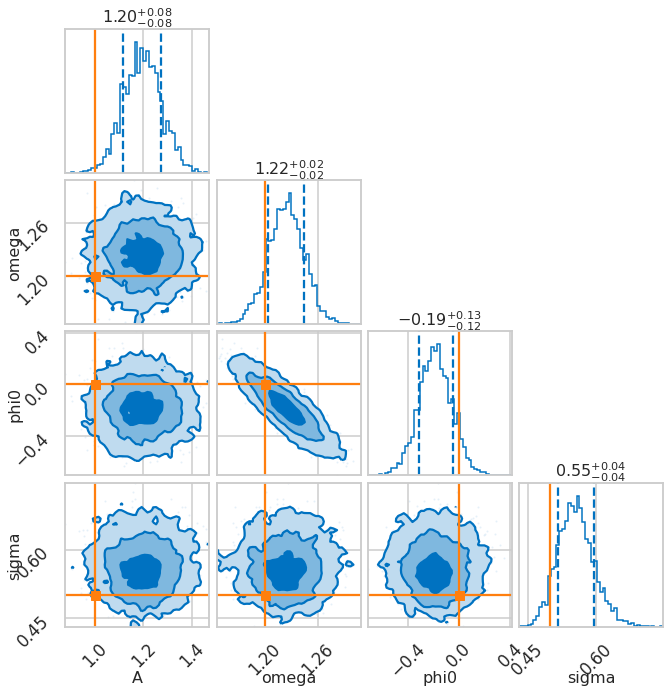

In [72]:
# Dashed lines give 90% C.I.
result.plot_corner()

# What is going on here?

- Bilby has used a [Nested Sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) algorithm [dynesty](https://dynesty.readthedocs.io/en/latest/) to evaluate the posteriors
- The posterior output are a set of samples
- The samples are "points drawn from the posterior distribution"
- Stored in a pandas DataFrame

In [73]:
result.posterior.head()

,A,omega,phi0,sigma,log_likelihood,log_prior
0,0.878080,1.216286,0.078435,0.655561,-92.506276,-2.531024
1,1.054049,1.199713,-0.195306,0.451687,-91.704720,-2.531024
2,1.156610,1.177656,-0.148791,0.510738,-91.107329,-2.531024
3,1.471829,1.218195,0.018363,0.610840,-90.721538,-2.531024
4,0.943427,1.224188,-0.347790,0.514552,-90.475840,-2.531024


## Using the samples

You can use the samples in all sorts of ways, for example let's plot the 1D marginalised distribution for omega

(0.0, 25.0)

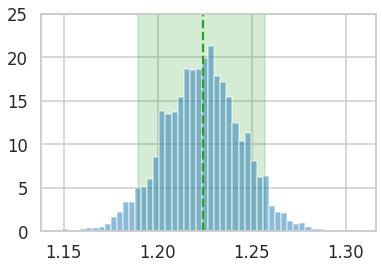

In [74]:
#previous one is 90% CI, here is 95% CI
omega_samples = result.posterior["omega"]
median = np.quantile(omega_samples, 0.5)
low_bound = np.quantile(omega_samples, 0.05)
upper_bound = np.quantile(omega_samples, 0.95)

plt.fill_between([low_bound, upper_bound], 0, 200, color='C2', alpha=0.2)
plt.axvline(median, ls="--", color="C2")
_ = plt.hist(omega_samples, bins=50, density=True, alpha=0.5)
plt.ylim(0, 25)

### Looking at the posterior uncertainty
We might want to know what range of curves are data supports

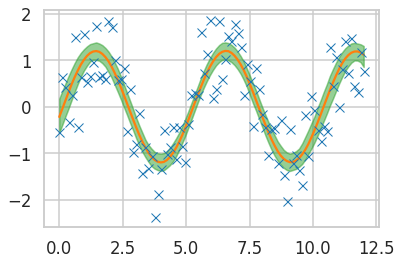

In [75]:
y_pred = []
for _, sample in result.posterior.sample(1000).iterrows():
    y_pred.append(modelB(time, **{k:sample[k] for k in likelihood.model_parameters.keys()}))
    
median = np.quantile(y_pred, 0.5, axis=0)
lower = np.quantile(y_pred, 0.01, axis=0)
upper = np.quantile(y_pred, 0.99, axis=0)
plt.plot(time, median, color='C1')
plt.fill_between(time, lower, upper, color="C2", alpha=0.5)

plt.plot(time, yobs, 'x')
plt.show()

## Using the `results` objects

The `result` object is where all the output is stored. It is stored to disk (by default in a `json` format)

In [76]:
print(result.outdir)  # Set in the `run_sampler()` call

/content/test-outdir


In [77]:
!ls /home/user1/test-outdir

ls: cannot access '/home/user1/test-outdir': No such file or directory


In [78]:
!head /home/user1/test-outdir/black-box_result.json

head: cannot open '/home/user1/test-outdir/black-box_result.json' for reading: No such file or directory


## You can load the result up

In [79]:
result_loaded = bilby.result.read_in_result("test-outdir/black-box_result.json")

## Check a traceplot of the runs

display: test-outdir/black-box_checkpoint_trace.png

![image](https://github.com/GregoryAshton/GWParameterEstimationWorkshop2020/blob/master/notebooks/test-outdir/black-box_checkpoint_trace.png?raw=1)

## Access attributes

In [80]:
print(result_loaded.log_evidence)
print(result_loaded.injection_parameters)
print(result_loaded.sampling_time)  # In seconds
print(result.version)

-91.8984770982498
{'A': 1, 'omega': 1.2, 'phi0': 0, 'sigma': 0.5}
12.556419
bilby=1.0.1: release


## Make corner plots with truths

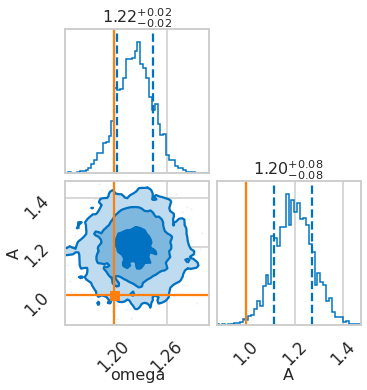

In [81]:
result.plot_corner(dict(omega=omega_true, A=1))

## Make corner plots without truths

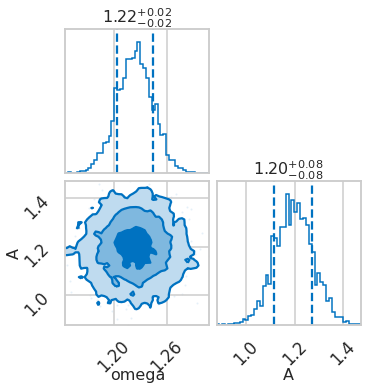

In [82]:
result.plot_corner(['omega', 'A'])

## Priors

- Bilby includes lots of built in priors
- Like the likelihood you can create your own from scratch

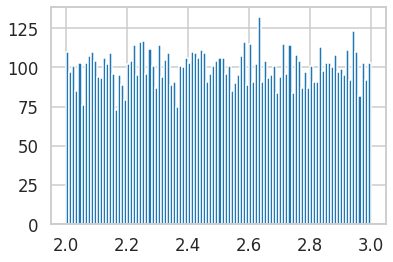

In [83]:
log_unif = bilby.core.prior.Uniform(2, 3)
_ = plt.hist(log_unif.sample(10000), bins=100)

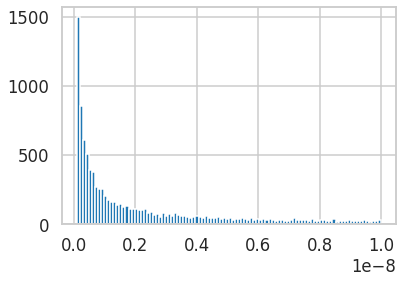

In [84]:
log_unif = bilby.core.prior.LogUniform(1e-10, 1e-8)
_ = plt.hist(log_unif.sample(10000), bins=100)

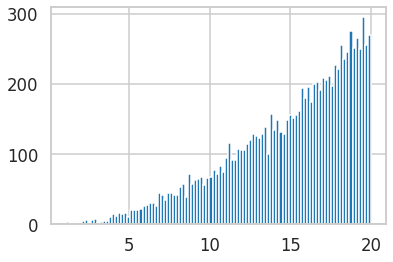

In [85]:
power = bilby.core.prior.PowerLaw(alpha=2, minimum=1, maximum=20)
_ = plt.hist(power.sample(10000), bins=100)

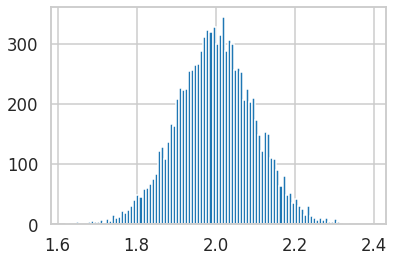

In [86]:
gauss = bilby.core.prior.Gaussian(mu=2, sigma=0.1)
_ = plt.hist(gauss.sample(10000), bins=100)

### We also provide the `PriorDict` which is useful for handling a set of priors

In [87]:
priors = bilby.prior.PriorDict(dict(
    x=bilby.prior.Uniform(0, 1, 'x'),
    y=bilby.prior.Cosine('y')))
prior_samples = priors.sample(10000)
prior_samples

{'x': array([0.26123002, 0.0343993 , 0.77393233, ..., 0.96363585, 0.4939324 ,
        0.80306942]),
 'y': array([-0.25230758, -0.46898263, -0.18644022, ..., -0.17307095,
        -0.0089523 ,  0.59004582])}

## Plotting the prior samples

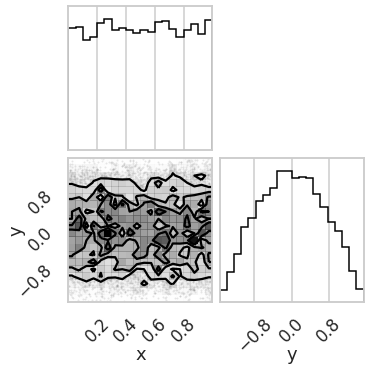

In [88]:
import corner
prior_samples_array = np.array([prior_samples['x'], prior_samples['y']]).T
corner.corner(prior_samples_array, labels=['x', 'y'])
plt.show()

## Additional resources

- Greg Ashton's [OzGrav ECR slides](https://github.com/GregoryAshton/Inference-Data-analysis-hands-on-training) on which these where based.

- Moritz Hübner's introduction to bilby [on colab](https://colab.research.google.com/drive/1PiQD4ZVA-cteqpcrhEZThkY9BLJAsdrK)

- Colm Talbot's introduction to GW inference with bilby [on colab](https://colab.research.google.com/gist/ColmTalbot/58dacd07a820d96ed0e1c43e2bf824c1/gravitational-wave-transient-inference-with-bilby.ipynb)